Up next, we will generate the external forcing conditions that will be used in the California regional model.

First, import packages create and visualize the model fields here:

In [160]:
# import the modules for computation, plotting, and reading files
import os
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import cmocean.cm as cm

# import the necessary modules from eccoseas
from eccoseas.ecco import exf
from eccoseas.ecco import io
from eccoseas.downscale import hFac
from eccoseas.downscale import horizontal

## Constructing External Forcing Files
For this example, we will use the external forcing fields from the ECCO Version 5 state estimate. We will prepare these fields in 5 steps:
1. download 7 external forcing fields used in the ECCO model
2. read the external forcing fields used in the ECCO model as well as the ECCO grid
3. read in the bathymetry for the regional model as well as its grid
4. interpolate the ECCO fields onto the regional model grid and store each as a binary file
5. plot the interpolated fields to ensure they look as expected

### Step 1: Download the ECCO external forcing fields
To begin, download the ECCO external forcing fields used in the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/era_xx). For this regional model, we will downloaded the following list of files forfor the year 2008:

| Variable | File Name |
| -------- | --------- |
|ATEMP|EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl|
|AQH|EIG_spfh2m_plus_ECCO_v4r1_ctrl|
|SWDOWN|EIG_dsw_plus_ECCO_v4r1_ctrl|
|LWDOWN|EIG_dlw_plus_ECCO_v4r1_ctrl|
|UWIND|EIG_u10m|
|VWIND|EIG_v10m|
|PRECIP|EIG_rain_plus_ECCO_v4r1_ctrl|

These fields are stored in the following direectory:

In [164]:
data_folder = 'ECCO_data_2024'
input_dir = os.getcwd()

### Step 2: Read in the external forcing fields
To read in the ECCO fields, I will rely on the `exf` module from the `eccoseas` package. We will loop through all of the files we downloaded, reading them in with the `exf` module:

In [167]:
# make a file dictionary to loop over
file_prefix_dict = {'ATEMP':'EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl',
                    'AQH':'EIG_spfh2m_plus_ECCO_v4r1_ctrl',
                    'SWDOWN':'EIG_dsw_plus_ECCO_v4r1_ctrl',
                    'LWDOWN':'EIG_dlw_plus_ECCO_v4r1_ctrl',
                    'UWIND':'EIG_u10m',
                    'VWIND':'EIG_v10m',
                    'PRECIP':'EIG_rain_plus_ECCO_v4r1_ctrl'}

variable_names = list(file_prefix_dict.keys())

In [169]:
# make a list to hold all of the exf grids
exf_grids = []
year=2024

# loop through each variable to read in the grid
for field in variable_names:
    exf_lon, exf_lat, exf_grid = exf.read_ecco_exf_file(data_folder, file_prefix_dict[field], year)
    exf_grids.append(exf_grid)

With an eye toward the interpolation that will come in step 4, we will make 2D grids of longitudes and latitudes to use in the interpolation

In [171]:
Exf_Lon, Exf_Lat = np.meshgrid(exf_lon, exf_lat)
ecco_points = np.column_stack([Exf_Lon.ravel(), Exf_Lat.ravel()])

We can visualize these grids as follows:

In [173]:
ecco_meta_dict = {'ATEMP':[-50, 30, cm.thermal, '$^{\circ}$C'],
             'AQH':[0, 0.025, cm.tempo, 'kg/kg'],
             'PRECIP':[0, 1e-6, cm.tempo, 'm/s'],
             'SWDOWN':[-1000,0,cm.solar,'W/m$^2$'],
             'LWDOWN':[-500, 0,cm.solar,'W/m$^2$'],
             'UWIND':[-20, 20, cm.balance, 'm/s'],
             'VWIND':[-20, 20, cm.balance, 'm/s']}
ecco_variable_names = list(ecco_meta_dict.keys())

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_55932/3984358176.py:1: SyntaxWarning: invalid escape sequence '\c'
  ecco_meta_dict = {'ATEMP':[-50, 30, cm.thermal, '$^{\circ}$C'],


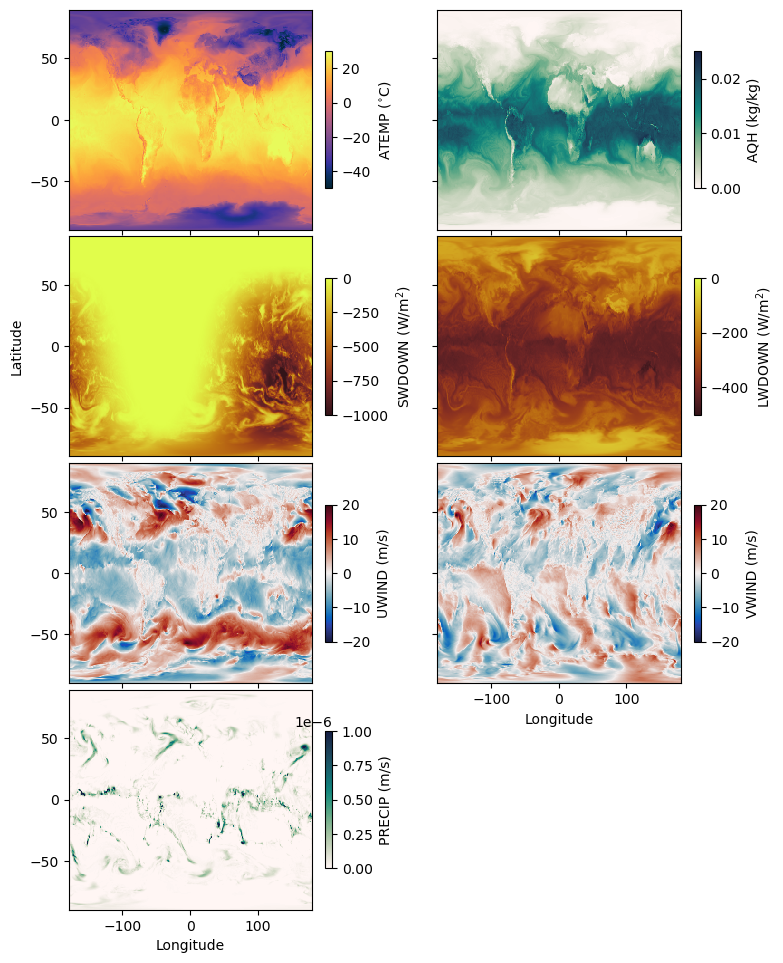

In [174]:
fig = plt.figure(figsize=(8,10))
gs = GridSpec(4, 2, wspace=0.4, hspace=0.03, 
              left=0.11, right=0.9, top=0.95, bottom=0.05)


for i, exf_grid in enumerate(exf_grids):
    variable_name = ecco_variable_names[i]

    # choose just the first timestep for plotting
    exf_grid = exf_grid[0, :, :]
    
    ax1 = fig.add_subplot(gs[i])
    C = plt.pcolormesh(Exf_Lon, Exf_Lat, exf_grid,
                       vmin=ecco_meta_dict[variable_names[i]][0],
                       vmax=ecco_meta_dict[variable_names[i]][1],
                       cmap=ecco_meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+ecco_meta_dict[variable_names[i]][3]+')',fraction=0.026)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')

plt.show()

As we can see, the external forcing fields are global - and we can use this to our advantage in the interpolation since we don't need to "spread" these variable like the oceanic variables.

### Step 3: Read in the Regional Model Grid
Next, we will recreate the grid we will use in the regional model and read in the bathymetry file (see previous notebooks for details) in order to generate the land mask:

In [177]:
# define the input directory (constructed in the previous notebook for bathymetry)
# this directory should already have the bathymetry file called CA_bathymetry.bin
input_dir = os.getcwd()

In [178]:
# define the parameters that will be used in the data file
delX = 1/480
delY = 1/480
xgOrigin = -120.9 #-135 
ygOrigin =  34.9 #29
n_rows = 180 #360
n_cols = 180 #240

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)


# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'SLO_bathymetry.bin'),'>f4').reshape(np.shape(XC))

In [179]:
theta = 10
thetabc = 5
l = 0.8
taub = 1
taui = 1000

solution = (theta - ((1 -l)*thetabc + l*theta))/((1-l)*taub + l*taui)
print(solution)

0.0012496875781054736


In [180]:
# create the surface mask
#ecco_DRF_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='DRF')
#delR = np.array([10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,
                 # 10.03, 10.11, 10.32, 10.80, 11.76, 13.42, 16.04, 19.82, 24.85,
                 # 31.10, 38.42, 46.50, 55.00, 63.50, 71.58, 78.90, 85.15, 90.18,
                 # 93.96, 96.58, 98.25, 99.25,100.01,101.33,104.56,111.33,122.83,
                 # 139.09,158.94,180.83,203.55,226.50,249.50,272.50,295.50,318.50,
                 # 341.50,364.50,387.50,410.50,433.50,456.50])
# delR = ecco_DRF_tiles[1]
delR = np.arange(0, 40, 0.5)
surface_mask = hFac.create_hFacC_grid(bathy, delR)[0,:,:]
surface_mask[surface_mask>0]=1
surface_mask = surface_mask.astype(int)

/opt/anaconda3/envs/ms274/lib/python3.12/site-packages/eccoseas/downscale/hFac.py:201: RuntimeWarning: divide by zero encountered in divide
  recip_drF = 1 / drF
/opt/anaconda3/envs/ms274/lib/python3.12/site-packages/eccoseas/downscale/hFac.py:215: RuntimeWarning: invalid value encountered in multiply
  hFac_loc = (RL_3d - R_low_3d) * recip_drF_3d


To double check the mask was created as expected, we will plot it in comparison to the bathymetry here:

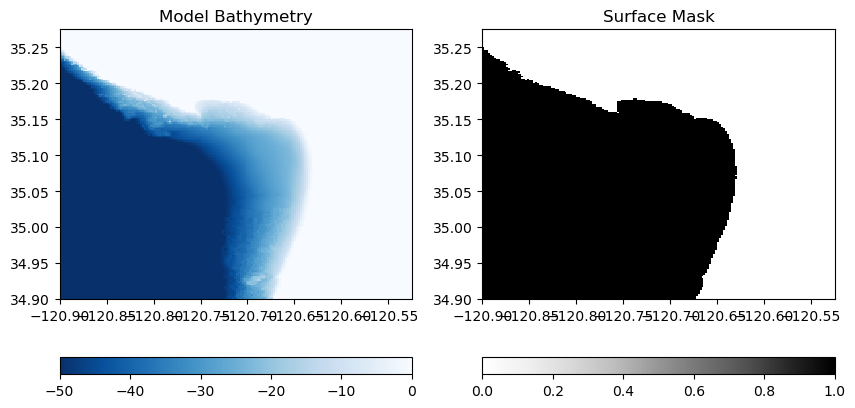

In [182]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-50, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, surface_mask, vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Surface Mask')

plt.show()

### Step 4: Interpolate the Fields onto the Model Grid
Next, we will interpolate the ECCO external fields Iwe read in onto the regional model domain. Since spreading is not necessary, we can just use the `scipy` package for interpolation. This interpolation is bundled efficiently into the `downscale_exf_field` function in **eccoseas**.

In [184]:
# ensure the output folder exists
if 'exf' not in os.listdir(input_dir):
    os.mkdir(os.path.join(input_dir, 'exf'))

In [185]:
# tri is the interpolation model and only needs to be computed once
# it is reused after it is computed in the downscale function
tri = None

# loop through each variable and corresponding ECCO grid
for variable_name, exf_grid in zip(variable_names, exf_grids):

    # print a message to keep track of which variable we are working on
    print('    - Interpolating the '+variable_name+' grid')

    # create a grid of zeros to fill in
    interpolated_grid, tri = horizontal.downscale_exf_field(ecco_points, exf_grid,
                                                          XC, YC, surface_mask, tri)

    # convert ECCO values to MITgcm defaults
    if variable_name=='ATEMP':
        interpolated_grid += 273.15
    if variable_name in ['SWDOWN','LWDOWN']:
        interpolated_grid *=-1

    # output the interpolated grid
    output_file = os.path.join(input_dir,'exf',variable_name+'_'+str(year))
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

    - Interpolating the ATEMP grid
    - Interpolating the AQH grid
    - Interpolating the SWDOWN grid
    - Interpolating the LWDOWN grid
    - Interpolating the UWIND grid
    - Interpolating the VWIND grid
    - Interpolating the PRECIP grid


### Step 5: Plotting the External Forcing Fields
Now that the fields have been generated, we will plot them to ensure they look as expected. First, generate some metadata for each one:

In [272]:
meta_dict = {'ATEMP':[285, 290, cm.thermal, '$^{\circ}$C'],
             'AQH':[0, 0.025, cm.tempo, 'kg/kg'],
             'PRECIP':[0, 1e-6, cm.tempo, 'm/s'],
             'SWDOWN':[20,200,cm.solar,'W/m$^2$'],
             'LWDOWN':[-100, 500,cm.solar,'W/m$^2$'],
             'UWIND':[-20, 20, cm.balance, 'm/s'],
             'VWIND':[-10, 0, cm.balance, 'm/s'],
             'RUNOFF':[0, 2e-8, cm.tempo, 'm/s']}

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_55932/422567562.py:1: SyntaxWarning: invalid escape sequence '\c'
  meta_dict = {'ATEMP':[285, 290, cm.thermal, '$^{\circ}$C'],


Then, create all of the subplots:

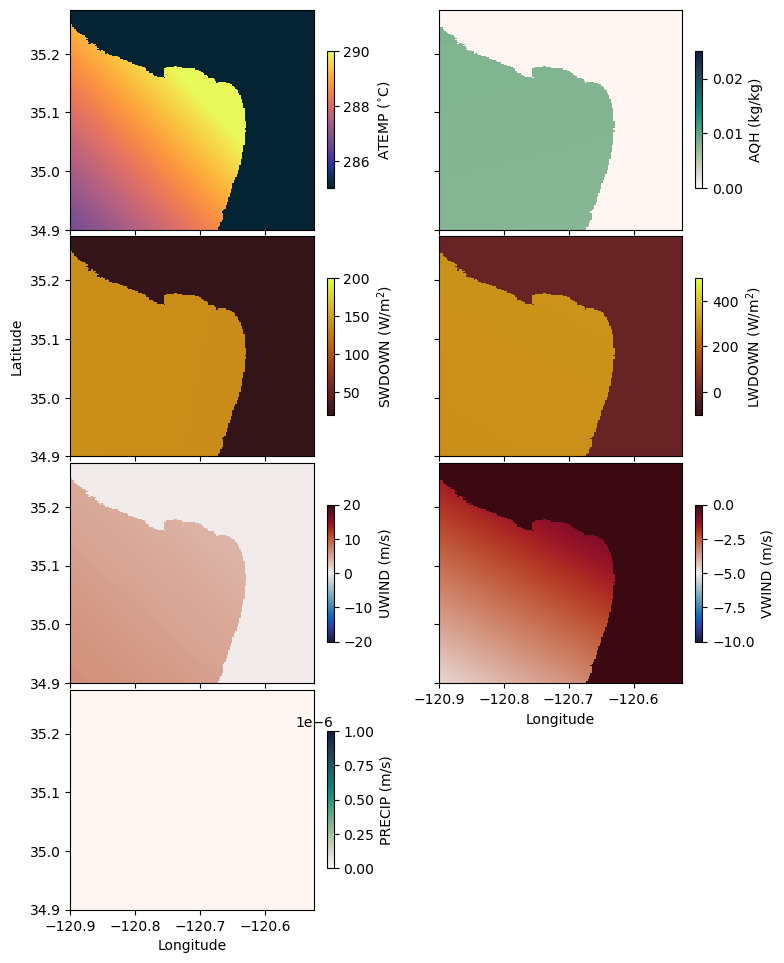

In [276]:
fig = plt.figure(figsize=(8,10))
gs = GridSpec(4, 2, wspace=0.4, hspace=0.03, 
              left=0.11, right=0.9, top=0.95, bottom=0.05)


for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    CA_exf_grid = np.fromfile(os.path.join(input_dir,'exf',variable_name+'_'+str(year)),'>f4')
    CA_exf_grid = CA_exf_grid.reshape((np.shape(exf_grid)[0],np.shape(XC)[0], np.shape(XC)[1]))

    # choose just the first timestep for plotting
    CA_exf_grid = CA_exf_grid[600, :, :]
    
    ax1 = fig.add_subplot(gs[i])
    C = plt.pcolormesh(XC, YC, CA_exf_grid,
                       vmin=meta_dict[variable_names[i]][0],
                       vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.026)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')

plt.show()

In [291]:


#for i in range(len(


#CA_exf_grid = CA_exf_grid[600, i, :]

len(CA_exf_grid[0])

TypeError: object of type 'numpy.float32' has no len()

Looks good! Next, we'll take a look at the boundary conditions.